In [1]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
%matplotlib inline

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

env = gym.make('Pong-v0')

learning_rate = 0.01
state_size = 6400
n_actions = env.action_space.n #number of available actions

learning_rate = 0.01
episodes = 100
epochs = 100
base_or_nah = True # baseline or not

In [21]:
def discount_rewards(r, gamma = .99, normalize = False):
    """discount rewards and return a list"""
    discount_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * gamma + r[t]
        discount_r[t] = running_add      
    
    if normalize:
        mean = np.mean(discount_r)
        std = np.std(discount_r)
        discount_r = (discount_r - mean) / (std)
    
    return list(discount_r)

def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80,80])

## build model
class modeling():
    def __init__(self, learning_rate=0.01, state_size=state_size, action_size=n_actions, name="PolicyTuning"):
    #state, actions, discounted_episods_rewards_, learning_rate:
        with tf.name_scope("inputs"):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name="states")
            self.actions_ = tf.placeholder(tf.int32, [None, action_size], name="actions")
            self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,], name="expected_episode_rewards")
        
        with tf.name_scope("conv1"):
            self.conv1 = tf.contrib.layers.fully_connected(self.inputs_, num_outputs=1600, weights_initializer=tf.contrib.layers.xavier_initializer())

            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1, training = True, epsilon=learning_rate, name="batch_norm1")
            self.conv1_out = tf.nn.relu(self.conv1_batchnorm, name="conv_out")

        with tf.name_scope("conv2"):
            self.conv2 = tf.contrib.layers.fully_connected(self.conv1_out, num_outputs=400, weights_initializer=tf.contrib.layers.xavier_initializer())

            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2, training = True, epsilon=learning_rate, name="batch_norm2")
            self.conv2_out = tf.nn.relu(self.conv2_batchnorm, name="conv_out")

        with tf.name_scope("conv3"):
            self.conv3 = tf.contrib.layers.fully_connected(self.conv2_out, num_outputs=n_actions, weights_initializer=tf.contrib.layers.xavier_initializer())

            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3, training = True, epsilon=learning_rate, name="batch_norm3")
            self.conv3_out = tf.nn.relu(self.conv3_batchnorm, name="conv_out")

        with tf.name_scope("flatten"):
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            self.logits = tf.layers.dense(inputs = self.flatten, units = n_actions, activation = tf.nn.relu, 
                                     kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

        with tf.name_scope("softmax"):
            self.action_distribution = tf.nn.softmax(self.conv3_out)

        with tf.name_scope("loss"):
            self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.conv3_out, 
                                                                            labels = self.actions_)
            self.to_op = tf.multiply(self.cross_entropy, self.discounted_episodes_rewards_)
            self.loss = tf.reduce_mean(self.to_op)
            self.learn= tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

class Baseline():
    def __init__(self, learning_rate=0.01, state_size=6400, name="Baseline"):
        with tf.variable_scope(name):

            # Store Variables
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,], name="discounted_episodes_rewards_")

            # Hidden Layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, 1600, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 100, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 1, activation_fn=None, 
                                                                 weights_initializer=tf.contrib.layers.xavier_initializer())

            # Define Loss
            self.loss = tf.reduce_mean(tf.square(self.fc3 - self.discounted_episodes_rewards_), name="mse")

            # Adjust Network
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [24]:
tf.reset_default_graph()
Pong = modeling(name='Pong', learning_rate=learning_rate, state_size=state_size, action_size=n_actions)
baseline = Baseline(name = 'Base', learning_rate=learning_rate, state_size=state_size)

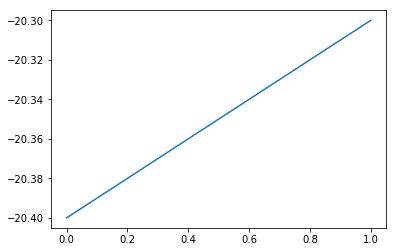

In [25]:
# Initialize the simulation
env.reset()

all_rewards = []

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(2):
        
        # save all states, actions, and rewards that happen 
        all_states, all_actions, all_discount_rewards = [], [], []
        running_rewards = []
        
        for episode in range(10):
            
            state = env.reset()
            episode_rewards = []
            
            while True:            
                # get action prob distribution
                action_dist = sess.run(Pong.action_distribution, 
                                       feed_dict={Pong.inputs_: preprocess(state).reshape(1, state_size)})
                
                # select action per distribution
                action = np.random.choice(range(action_dist.shape[1]), p=action_dist.ravel())
                new_state, reward, done, _ = env.step(action)
                
                # record all observed values
                all_states.append(preprocess(state).reshape(1, state_size))
                episode_rewards.append(reward)
                
                # action 0 or 1
                which_action = np.zeros(action_dist.shape[1])
                which_action[action] = 1
                all_actions.append(which_action)
                
                # reset current state to be new state
                state = new_state
                
                if done:
                    # Calculate discounted reward per episode
                    dis_rewards = discount_rewards(episode_rewards)
                    all_discount_rewards += dis_rewards
                    
                    # record reward per episode
                    running_rewards.append(sum(episode_rewards))
                    break
        
        if base_or_nah: # baseline adjustment
            original_r = all_discount_rewards.copy()
            baseline_r = sess.run(baseline.fc3, feed_dict={baseline.inputs_ : np.vstack(all_states)})
            all_discount_rewards -= np.hstack(baseline_r)

            # train on baseline
            _, _= sess.run([baseline.loss, baseline.learn], 
                        feed_dict={baseline.inputs_: np.vstack(all_states),
                        baseline.discounted_episodes_rewards_: original_r })
         
        # Policy Gradient Descent Update
        _, _= sess.run([Pong.loss, Pong.learn], 
                                     feed_dict={Pong.inputs_: np.vstack(all_states),
                                     Pong.actions_: np.vstack(all_actions),
                                     Pong.discounted_episodes_rewards_: all_discount_rewards })      
        
        # average reward per episodes in epoch
        all_rewards.append(np.mean(running_rewards))

# rewards over training epochs
plt.plot(all_rewards)